In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyspark.sql.functions as f
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .master("local") \
    .appName("xpto") \
    .getOrCreate()
sc = spark.sparkContext

23/04/15 11:55:31 WARN Utils: Your hostname, rhaydrick-6.local resolves to a loopback address: 127.0.0.1; using 10.227.159.211 instead (on interface en0)
23/04/15 11:55:31 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/04/15 11:55:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
text_file = sc.textFile("datasets/shakespeare.txt")

In [3]:
df = text_file.flatMap(lambda line: line.split(' '))\
    .map(lambda word: (word, 1))\
    .reduceByKey(lambda w1, w2: w1 + w2) \
    .collect()

In [4]:
df_sorted = sorted(df, key=lambda x: x[1], reverse=True)
df_sorted[:10]

[('the', 611),
 ('I', 546),
 ('and', 469),
 ('to', 432),
 ('a', 398),
 ('of', 361),
 ('my', 315),
 ('is', 292),
 ('in', 280),
 ('that', 252)]

# Fire departament

In [5]:
# Load file
df_fire = spark.read.csv('datasets/sf-fire-calls.csv', header=True, inferSchema=True)
#Print Schema
df_fire.printSchema()

root
 |-- CallNumber: integer (nullable = true)
 |-- UnitID: string (nullable = true)
 |-- IncidentNumber: integer (nullable = true)
 |-- CallType: string (nullable = true)
 |-- CallDate: string (nullable = true)
 |-- WatchDate: string (nullable = true)
 |-- CallFinalDisposition: string (nullable = true)
 |-- AvailableDtTm: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Zipcode: integer (nullable = true)
 |-- Battalion: string (nullable = true)
 |-- StationArea: string (nullable = true)
 |-- Box: string (nullable = true)
 |-- OriginalPriority: string (nullable = true)
 |-- Priority: string (nullable = true)
 |-- FinalPriority: integer (nullable = true)
 |-- ALSUnit: boolean (nullable = true)
 |-- CallTypeGroup: string (nullable = true)
 |-- NumAlarms: integer (nullable = true)
 |-- UnitType: string (nullable = true)
 |-- UnitSequenceInCallDispatch: integer (nullable = true)
 |-- FirePreventionDistrict: string (nullable = true)
 

In [6]:
# Showing first 5 rows
df_fire.take(5)

23/04/15 11:55:42 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


[Row(CallNumber=20110016, UnitID='T13', IncidentNumber=2003235, CallType='Structure Fire', CallDate='01/11/2002', WatchDate='01/10/2002', CallFinalDisposition='Other', AvailableDtTm='01/11/2002 01:51:44 AM', Address='2000 Block of CALIFORNIA ST', City='SF', Zipcode=94109, Battalion='B04', StationArea='38', Box='3362', OriginalPriority='3', Priority='3', FinalPriority=3, ALSUnit=False, CallTypeGroup=None, NumAlarms=1, UnitType='TRUCK', UnitSequenceInCallDispatch=2, FirePreventionDistrict='4', SupervisorDistrict='5', Neighborhood='Pacific Heights', Location='(37.7895840679362, -122.428071912459)', RowID='020110016-T13', Delay=2.95),
 Row(CallNumber=20110022, UnitID='M17', IncidentNumber=2003241, CallType='Medical Incident', CallDate='01/11/2002', WatchDate='01/10/2002', CallFinalDisposition='Other', AvailableDtTm='01/11/2002 03:01:18 AM', Address='0 Block of SILVERVIEW DR', City='SF', Zipcode=94124, Battalion='B10', StationArea='42', Box='6495', OriginalPriority='3', Priority='3', FinalP

In [7]:
# Compute the number of distinct types of calls
df_fire.agg(f.countDistinct("CallType").alias("DistinctCallType")).show()


+----------------+
|DistinctCallType|
+----------------+
|              30|
+----------------+



In [8]:
# List the distinct types of calls
df_fire.select(f.col("CallType")).distinct().show(10, truncate=50)

+-----------------------------------+
|                           CallType|
+-----------------------------------+
|        Elevator / Escalator Rescue|
|                        Marine Fire|
|                 Aircraft Emergency|
|Confined Space / Structure Collapse|
|                     Administrative|
|                             Alarms|
|           Odor (Strange / Unknown)|
|      Citizen Assist / Service Call|
|                             HazMat|
|             Watercraft in Distress|
+-----------------------------------+
only showing top 10 rows



In [9]:
# Change the name of the column Delay to ResponseDelayinMins
df_fire = df_fire.withColumnRenamed('Delay', 'ResponseDelayinMins')
df_fire.printSchema()

root
 |-- CallNumber: integer (nullable = true)
 |-- UnitID: string (nullable = true)
 |-- IncidentNumber: integer (nullable = true)
 |-- CallType: string (nullable = true)
 |-- CallDate: string (nullable = true)
 |-- WatchDate: string (nullable = true)
 |-- CallFinalDisposition: string (nullable = true)
 |-- AvailableDtTm: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Zipcode: integer (nullable = true)
 |-- Battalion: string (nullable = true)
 |-- StationArea: string (nullable = true)
 |-- Box: string (nullable = true)
 |-- OriginalPriority: string (nullable = true)
 |-- Priority: string (nullable = true)
 |-- FinalPriority: integer (nullable = true)
 |-- ALSUnit: boolean (nullable = true)
 |-- CallTypeGroup: string (nullable = true)
 |-- NumAlarms: integer (nullable = true)
 |-- UnitType: string (nullable = true)
 |-- UnitSequenceInCallDispatch: integer (nullable = true)
 |-- FirePreventionDistrict: string (nullable = true)
 

In [10]:
# List the calltypes and ResponseDelayinMins of the calls that were longer than 500 minutes
df_fire.filter(f.col("ResponseDelayinMins") > 500).select("CallType", "ResponseDelayinMins").show()

+----------------+-------------------+
|        CallType|ResponseDelayinMins|
+----------------+-------------------+
|   Assist Police|          628.61664|
|  Structure Fire|          751.93335|
|  Structure Fire|          949.11664|
|  Structure Fire|             931.45|
|          Alarms|            1844.55|
|  Structure Fire|          535.93335|
|  Structure Fire|             734.05|
|Medical Incident|              721.4|
|  Structure Fire|          1370.2333|
+----------------+-------------------+



In [11]:
# Convert date as string in the dataset to Date types
# Use date/timestamp functions from spark.sql.functions: to_timestamp() and to_date()
# Drop origin columns
# CallDate (string) -> IncidentDate (“MM/dd/yyyy”)
# WatchDate (string) -> OnWatchDate (“MM/dd/yyyy”)
# AvailableDtTm (string) -> AvailableDtTS ("MM/dd/yyyy hh:mm:ss a")

df_fire_2 = df_fire.withColumn("AvailableDtTS", f.to_timestamp("AvailableDtTm", 'MM/dd/yyyy hh:mm:ss a'))\
    .withColumn("OnWatchDate", f.to_date("WatchDate", 'MM/dd/yyyy'))\
    .withColumn("IncidentDate",f.to_date("CallDate", 'MM/dd/yyyy')).drop("AvailableDtTm", "WatchDate", "CallDate")

# Print the schema of the new dataframe
df_fire_2.printSchema()

root
 |-- CallNumber: integer (nullable = true)
 |-- UnitID: string (nullable = true)
 |-- IncidentNumber: integer (nullable = true)
 |-- CallType: string (nullable = true)
 |-- CallFinalDisposition: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Zipcode: integer (nullable = true)
 |-- Battalion: string (nullable = true)
 |-- StationArea: string (nullable = true)
 |-- Box: string (nullable = true)
 |-- OriginalPriority: string (nullable = true)
 |-- Priority: string (nullable = true)
 |-- FinalPriority: integer (nullable = true)
 |-- ALSUnit: boolean (nullable = true)
 |-- CallTypeGroup: string (nullable = true)
 |-- NumAlarms: integer (nullable = true)
 |-- UnitType: string (nullable = true)
 |-- UnitSequenceInCallDispatch: integer (nullable = true)
 |-- FirePreventionDistrict: string (nullable = true)
 |-- SupervisorDistrict: string (nullable = true)
 |-- Neighborhood: string (nullable = true)
 |-- Location: string (nullable =

In [12]:
# Show the first 5 records of each dataframe for these columns
df_fire_2.select("IncidentDate", "OnWatchDate", "AvailableDtTS").show(5)

+------------+-----------+-------------------+
|IncidentDate|OnWatchDate|      AvailableDtTS|
+------------+-----------+-------------------+
|  2002-01-11| 2002-01-10|2002-01-11 01:51:44|
|  2002-01-11| 2002-01-10|2002-01-11 03:01:18|
|  2002-01-11| 2002-01-10|2002-01-11 02:39:50|
|  2002-01-11| 2002-01-10|2002-01-11 04:16:46|
|  2002-01-11| 2002-01-10|2002-01-11 06:01:58|
+------------+-----------+-------------------+
only showing top 5 rows



In [13]:
df_fire.select("CallDate", "WatchDate", "AvailableDtTm").show(5, truncate=30)

+----------+----------+----------------------+
|  CallDate| WatchDate|         AvailableDtTm|
+----------+----------+----------------------+
|01/11/2002|01/10/2002|01/11/2002 01:51:44 AM|
|01/11/2002|01/10/2002|01/11/2002 03:01:18 AM|
|01/11/2002|01/10/2002|01/11/2002 02:39:50 AM|
|01/11/2002|01/10/2002|01/11/2002 04:16:46 AM|
|01/11/2002|01/10/2002|01/11/2002 06:01:58 AM|
+----------+----------+----------------------+
only showing top 5 rows



In [14]:
# How many years of calls are in the dateset?
#df_fire_2.withColumn("Year", f.year("IncidentDate")).agg(f.countDistinct("Year").alias("AmountOfyears")).show()
df_fire_2 = df_fire_2.withColumn("Year", f.year("IncidentDate"))
df_fire_2.agg(f.countDistinct("Year").alias("AmountOfyears")).show()

+-------------+
|AmountOfyears|
+-------------+
|           19|
+-------------+



In [15]:
# How many years of calls are in the dateset, and how many calls per year?
df_fire_2.groupby(f.col("Year")).count().orderBy("Year").show()

+----+-----+
|Year|count|
+----+-----+
|2000| 5459|
|2001| 7713|
|2002| 8090|
|2003| 8499|
|2004| 8283|
|2005| 8282|
|2006| 8174|
|2007| 8255|
|2008| 8869|
|2009| 8789|
|2010| 9341|
|2011| 9735|
|2012| 9674|
|2013|10020|
|2014|10775|
|2015|11458|
|2016|11609|
|2017|12135|
|2018|10136|
+----+-----+



In [16]:
# How many calls occurred in November 2018?
df_fire_2.groupby(f.month("IncidentDate").alias('Nov'), f.col("Year").alias('Year'))\
    .count().where('Nov == 11').where('Year == 2018')\
    .select(f.col("Year"), f.col("count")).show()

+----+-----+
|Year|count|
+----+-----+
|2018|  199|
+----+-----+



In [17]:
# How many calls occurred in November of every year?
df_fire_2.groupby(f.month("IncidentDate").alias('Nov'), f.col("Year").alias('Year')) \
    .count().where('Nov == 11') \
    .select(f.col("Year"), f.col("count")).orderBy(f.col("Year"), ascending = False).show()

+----+-----+
|Year|count|
+----+-----+
|2018|  199|
|2017|  975|
|2016|  971|
|2015|  930|
|2014|  897|
|2013|  853|
|2012|  814|
|2011|  784|
|2010|  710|
|2009|  725|
|2008|  738|
|2007|  689|
|2006|  701|
|2005|  674|
|2004|  623|
|2003|  683|
|2002|  683|
|2001|  619|
|2000|  595|
+----+-----+



In [18]:
# List the most common types of fire calls with the count of each call type.
df_fire_2.groupby(f.col("CallType")).count().orderBy(f.col("count"), ascending=False ).show(10, truncate=50)

+-------------------------------+------+
|                       CallType| count|
+-------------------------------+------+
|               Medical Incident|113794|
|                 Structure Fire| 23319|
|                         Alarms| 19406|
|              Traffic Collision|  7013|
|  Citizen Assist / Service Call|  2524|
|                          Other|  2166|
|                   Outside Fire|  2094|
|                   Vehicle Fire|   854|
|Gas Leak (Natural and LP Gases)|   764|
|                   Water Rescue|   755|
+-------------------------------+------+
only showing top 10 rows



In [19]:
# Compute the average response time, and the minimum and maximum response times of all fire calls
df_fire_2.agg(
    f.sum(f.col("NumAlarms")),
    f.avg(f.col("ResponseDelayinMins")),
    f.min(f.col("ResponseDelayinMins")),
    f.max(f.col("ResponseDelayinMins"))
).show()

+--------------+------------------------+------------------------+------------------------+
|sum(NumAlarms)|avg(ResponseDelayinMins)|min(ResponseDelayinMins)|max(ResponseDelayinMins)|
+--------------+------------------------+------------------------+------------------------+
|        176170|      3.8923641541750413|             0.016666668|                 1844.55|
+--------------+------------------------+------------------------+------------------------+



In [20]:
# Did the number of fires in Xmas increased or decreased over time?

xmas = df_fire_2.withColumn("Day", f.dayofmonth("IncidentDate")).withColumn("Month", f.month("IncidentDate"))

In [21]:
xmas.head()

Row(CallNumber=20110016, UnitID='T13', IncidentNumber=2003235, CallType='Structure Fire', CallFinalDisposition='Other', Address='2000 Block of CALIFORNIA ST', City='SF', Zipcode=94109, Battalion='B04', StationArea='38', Box='3362', OriginalPriority='3', Priority='3', FinalPriority=3, ALSUnit=False, CallTypeGroup=None, NumAlarms=1, UnitType='TRUCK', UnitSequenceInCallDispatch=2, FirePreventionDistrict='4', SupervisorDistrict='5', Neighborhood='Pacific Heights', Location='(37.7895840679362, -122.428071912459)', RowID='020110016-T13', ResponseDelayinMins=2.95, AvailableDtTS=datetime.datetime(2002, 1, 11, 1, 51, 44), OnWatchDate=datetime.date(2002, 1, 10), IncidentDate=datetime.date(2002, 1, 11), Year=2002, Day=11, Month=1)

In [22]:
# xmas.select(f.col('Year'), f.col('Month'), f.col('Day')).where('Month == 12').where('Day == 25').count().show()
xmas.where(f.col('Month') == 12).where(f.col('Day') == 25)\
    .groupby('Year')\
    .count()\
    .orderBy('Year').show()

+----+-----+
|Year|count|
+----+-----+
|2000|   22|
|2001|   18|
|2002|   19|
|2003|   17|
|2004|   29|
|2005|   25|
|2006|   25|
|2007|   19|
|2008|   27|
|2009|   21|
|2010|   37|
|2011|   21|
|2012|   23|
|2013|   31|
|2014|   24|
|2015|   39|
|2016|   30|
|2017|   30|
+----+-----+



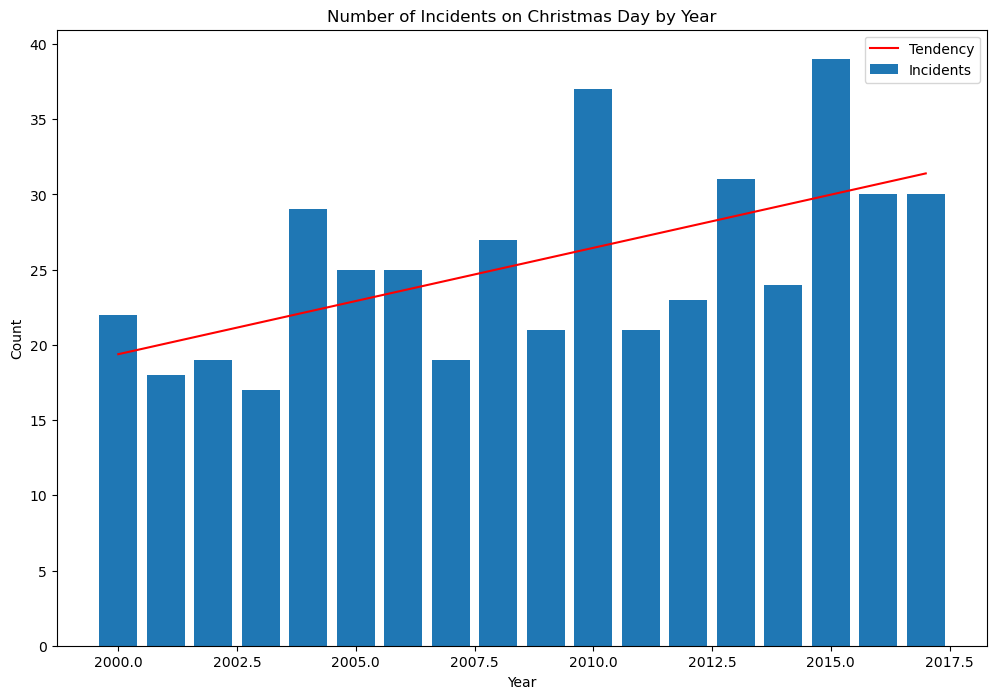

In [23]:
xmas_by_year = (
    xmas.where(f.col('Month') == 12)
    .where(f.col('Day') == 25)
    .groupby('Year')
    .count()
    .orderBy('Year')
)

# extract the data as a list of tuples
data = xmas_by_year.collect()


years = [int(row[0]) for row in data]
counts = [row[1] for row in data]

plt.figure(figsize=(12, 8))
plt.bar(years, counts, label='Incidents')

# add a tendency line
z = np.polyfit(years, counts, 1)
p = np.poly1d(z)

plt.plot(years, p(years), 'r-', label='Tendency')

plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Number of Incidents on Christmas Day by Year')
plt.legend()
plt.show()